# Project for a dairy farm

In this work, an analysis will be conducted on the data provided by the farmer of the dairy farm. There is data about the farm's cows (main_df), potential cows for purchase (buy_df), and the names of the cows' sires (dad_df). Using machine learning models, cows from the potential purchase list will be identified.

Work Plan:
1. Data Loading and Preprocessing
- Identifying missing values, duplicates
- Renaming columns
- Converting data to correct data types
2. Exploratory Data Analysis
- Visualizing data distribution by categories and quantitative features
3. Correlation Analysis
- Visualizing the dependence of quantitative features on cow milk yield
- Visualizing dependencies by dividing data into possible categories
4. Finding the Best Linear Regression Model to Predict Milk Yield
- Training a linear regression model to predict the yield of potential cows for purchase:
- Training on all available data from the main dataframe
- Training on data with modified attributes of Sugar-Protein Ratio and Energy Feed Unit
- Training on the main dataframe data combined with data from the dad dataframe (sire's name)
5. Finding the Best Logistic Regression Model to Predict Milk Taste
- Predicting milk taste based on data from the main dataframe
- Finding the best threshold value to minimize prediction errors
6. Determining Cows for Purchase
- Identifying cows with a yield of over 6000 kg and tasty milk from the list of potential cows

In [1]:
!pip install -U -q numpy pandas scipy matplotlib==3.7.3

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    accuracy_score
)
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 42

## Data Loading

In [3]:
main_df = pd.read_csv('../datasets/ferma_main.csv', sep=';', decimal = ',')
dad_df = pd.read_csv('../datasets/ferma_dad.csv', sep=';', decimal = ',')
buy_df = pd.read_csv('../datasets/cow_buy.csv', sep=';', decimal = ',')

##  Data Preprocessing

In [4]:
def df_description(df):
    print('shape: ', df.shape)
    display(df.head())
    df.info()
    display(pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm'))

In [5]:
df_description(main_df)

shape:  (634, 12)


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

,0
id,0.000000
"Удой, кг",0.000000
ЭКЕ (Энергетическая кормовая единица),0.000000
"Сырой протеин, г",0.000000
СПО (Сахаро-протеиновое соотношение),0.000000
Порода,0.000000
Тип пастбища,0.000000
порода папы_быка,0.000000
"Жирность,%",0.000000
"Белок,%",0.000000


In [6]:
pd.DataFrame(round(main_df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
id,0.000000
"Удой, кг",0.000000
ЭКЕ (Энергетическая кормовая единица),0.000000
"Сырой протеин, г",0.000000
СПО (Сахаро-протеиновое соотношение),0.000000
Порода,0.000000
Тип пастбища,0.000000
порода папы_быка,0.000000
"Жирность,%",0.000000
"Белок,%",0.000000


In [7]:
df_description(dad_df)

shape:  (629, 2)


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


,0
id,0.000000
Имя Папы,0.000000


In [8]:
df_description(buy_df)

shape:  (20, 7)


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


,0
Порода,0.000000
Тип пастбища,0.000000
порода папы_быка,0.000000
Имя_папы,0.000000
"Текущая_жирность,%",0.000000
"Текущий_уровень_белок,%",0.000000
Возраст,0.000000


In [9]:
main_df.columns = ['id', 'yield_kg', 'feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'breed', 'pasture',\
                   'dad_breed', 'fat_%', 'protein_%', 'milk_taste', 'age']
dad_df.columns = ['id', 'dad_name']
buy_df.columns = ['breed', 'pasture', 'dad_breed', 'dad_name', 'current_fat_%', 'current_protein_%', 'age']

In [10]:
print(main_df.info(), dad_df.info(), buy_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   yield_kg             634 non-null    int64  
 2   feed_unit            634 non-null    float64
 3   crude_protein_g      634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   breed                634 non-null    object 
 6   pasture              634 non-null    object 
 7   dad_breed            634 non-null    object 
 8   fat_%                634 non-null    float64
 9   protein_%            634 non-null    float64
 10  milk_taste           634 non-null    object 
 11  age                  634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Coun

Checking implicit duplicates

In [11]:
cat_attr_main = ['breed', 'pasture', 'dad_breed', 'milk_taste', 'age']
cat_attr_buy = ['breed', 'pasture', 'dad_breed', 'age']
cat_attr_dad = ['dad_name']

num_attr_main = ['yield_kg', 'feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_%', 'protein_%']
num_attr_buy = ['current_fat_%', 'current_protein_%']

In [12]:
for col in cat_attr_main:
    print(main_df[col].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']


In [13]:
main_df = main_df.apply(lambda x: x.replace({'Равнинные':'Равнинное', 'Айдиалл': 'Айдиал'}, regex=True))

In [14]:
for col in cat_attr_buy:
    print(buy_df[col].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['холмистое' 'равнинное']
['Айдиал' 'Соверин']
['более_2_лет' 'менее_2_лет']


In [15]:
buy_df = buy_df.apply(lambda x: x.replace({'равнинное':'Равнинное', 'холмистое': 'Холмистое'}, regex=True))

In [16]:
for col in cat_attr_dad:
    print(dad_df[col].unique())

['Буйный' 'Соловчик' 'Барин' 'Геркулес']


In [17]:
main_df.duplicated().sum()

5

In [18]:
main_df = main_df.drop_duplicates()
main_df.shape

(629, 12)

In [19]:
buy_df.duplicated().sum()

4

In [20]:
buy_df.duplicated()

0     False
1     False
2     False
3     False
4     False
5     False
6      True
7     False
8      True
9     False
10    False
11    False
12    False
13    False
14     True
15    False
16    False
17    False
18    False
19     True
dtype: bool

In [21]:
buy_df.sample(5)

,breed,pasture,dad_breed,dad_name,current_fat_%,current_protein_%,age
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,менее_2_лет
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет


## Exploratory Data Analysis

In [22]:
display(main_df.head())
display(buy_df.head())
display(dad_df.head())

,id,yield_kg,feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture,dad_breed,fat_%,protein_%,milk_taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


,breed,pasture,dad_breed,dad_name,current_fat_%,current_protein_%,age
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [23]:
def categorical_visualization(df, columns):
    for col in columns:
        counts = df[col].value_counts()
        labels = counts.index.tolist()
        sizes = counts.values.tolist()
        
        colors = sns.color_palette('viridis', len(labels))

        plt.figure(figsize=(2, 2))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.title(f'Distribution of {col}', fontsize=10)
        plt.axis('equal')
        plt.show()

def numerical_visualization(df, columns):
    print(df[columns].describe())
    for col in columns:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        sns.boxplot(y=df[col], ax=axes[0])
        axes[0].set_title(f'Boxplot for {col}', fontsize=10)
        axes[0].set_xlabel(col, fontsize=9)
        axes[0].set_ylabel('Values', fontsize=9)

        sns.histplot(df[col], bins=10, kde=True, ax=axes[1], color='skyblue')
        axes[1].set_title(f'Histogram of {col}', fontsize=10)
        axes[1].set_xlabel(col, fontsize=9)
        axes[1].set_ylabel('Frequency', fontsize=8)

        plt.tight_layout()
        plt.show()

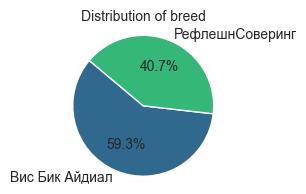

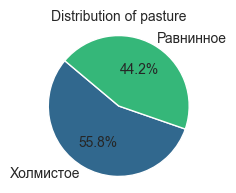

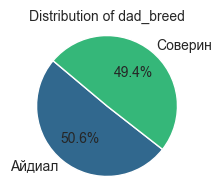

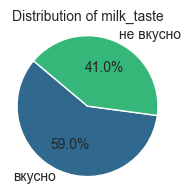

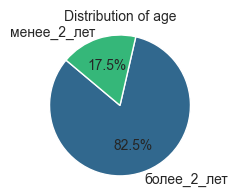

In [24]:
categorical_visualization(main_df, cat_attr_main)

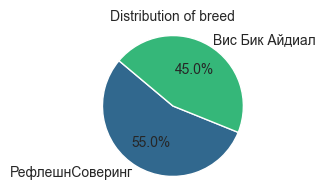

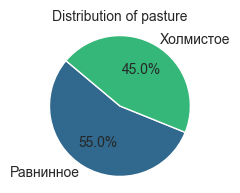

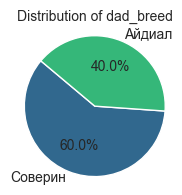

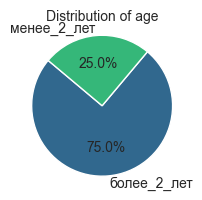

In [25]:
categorical_visualization(buy_df, cat_attr_buy)

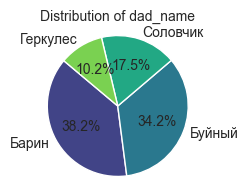

In [26]:
categorical_visualization(dad_df, cat_attr_dad)

           yield_kg   feed_unit  crude_protein_g  sugar_protein_ratio  \
count    629.000000  629.000000       629.000000           629.000000   
mean    6188.750397   14.543879      1923.364070             0.913116   
std     1644.795489    1.306408       182.956251             0.032203   
min     5204.000000   10.900000      1660.000000             0.840000   
25%     5751.000000   13.500000      1771.000000             0.890000   
50%     6133.000000   14.700000      1888.000000             0.930000   
75%     6501.000000   15.600000      2062.000000             0.940000   
max    45616.000000   16.800000      2349.000000             0.960000   

            fat_%   protein_%  
count  629.000000  629.000000  
mean     3.603657    3.075671  
std      0.168656    0.002549  
min      2.990000    3.069000  
25%      3.590000    3.074000  
50%      3.650000    3.076000  
75%      3.720000    3.077000  
max      3.750000    3.085000  


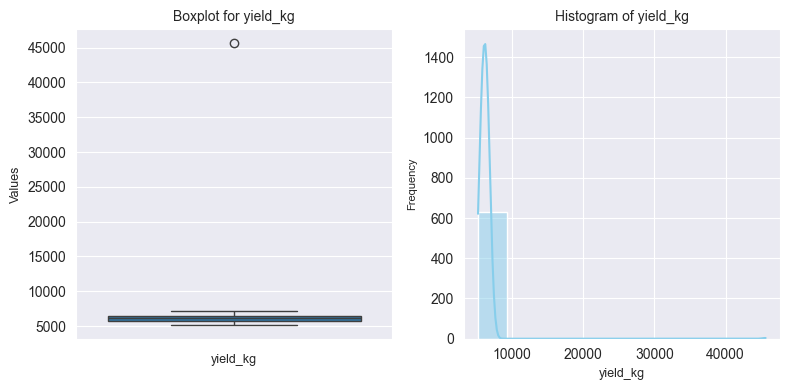

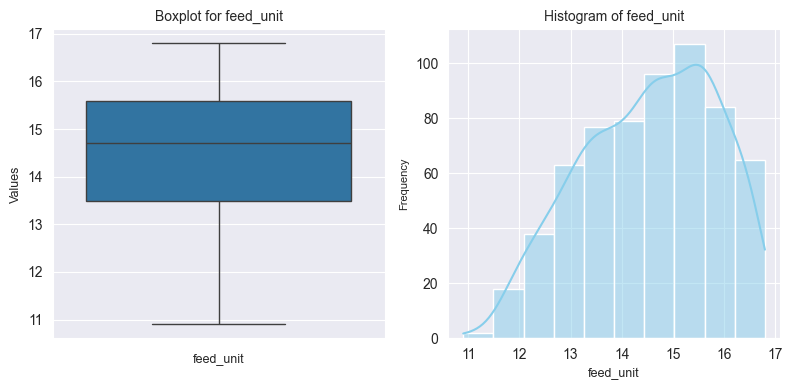

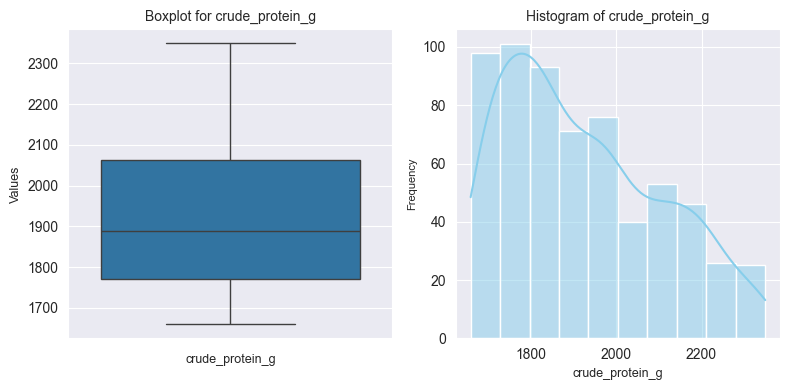

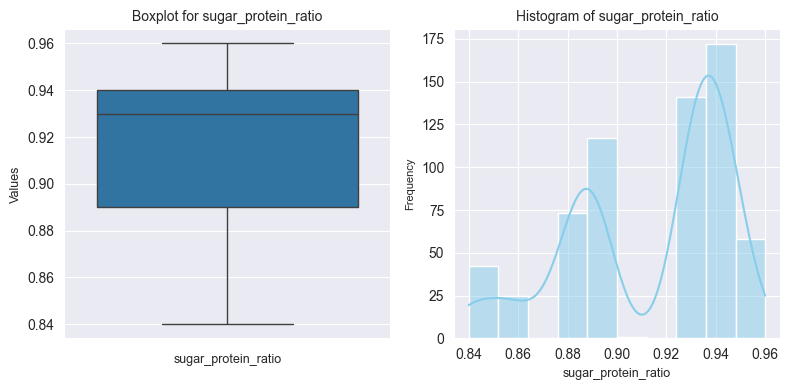

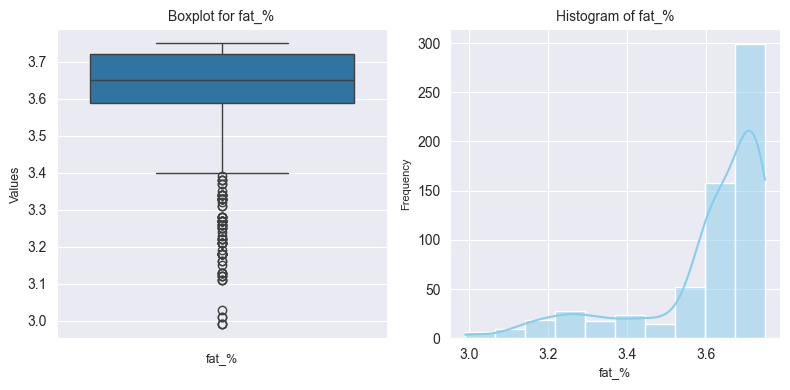

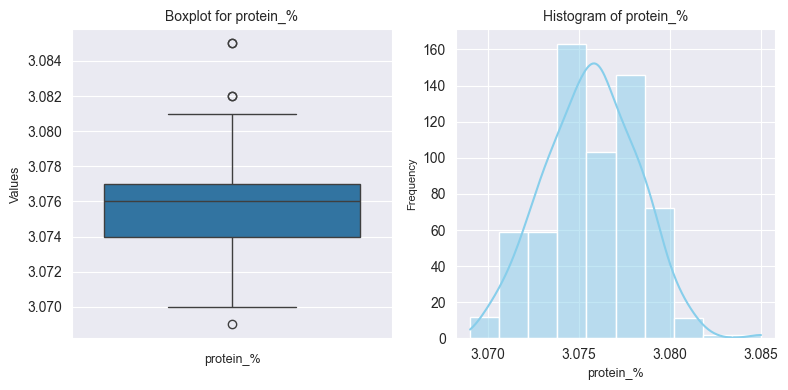

In [27]:
numerical_visualization(main_df, num_attr_main)

       current_fat_%  current_protein_%
count      20.000000          20.000000
mean        3.577500           3.069500
std         0.126818           0.010339
min         3.340000           3.046000
25%         3.510000           3.064000
50%         3.590000           3.074000
75%         3.650000           3.076000
max         3.770000           3.081000


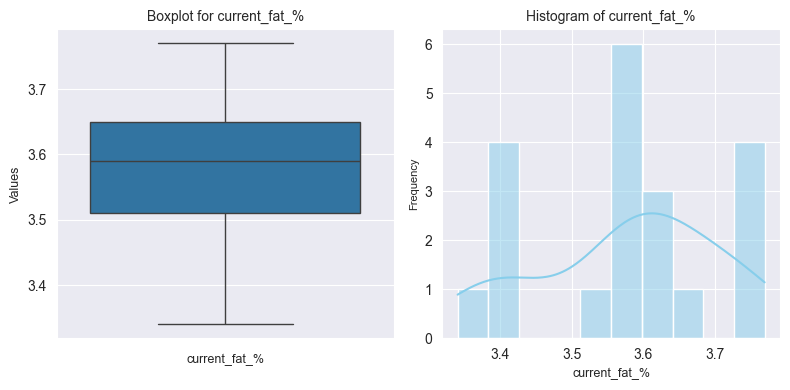

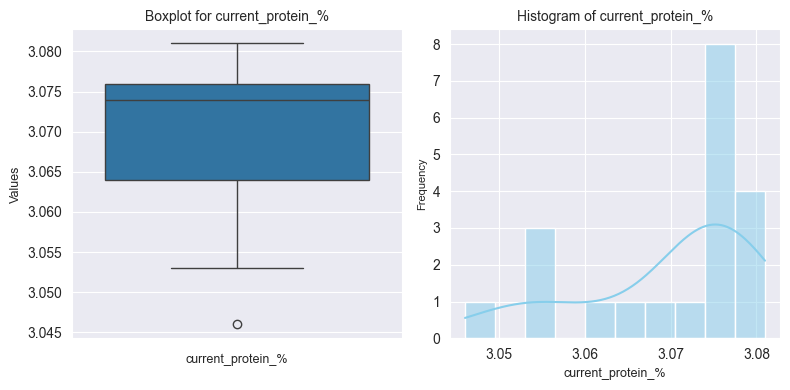

In [28]:
numerical_visualization(buy_df, num_attr_buy)

Dataframe main (Current farm data):
For all categorical features (except age), the number of cows in groups is relatively similar. For age: only 110 cows are less than 2 years old compared to 519 cows older than 2 years.
Numerical features: an outlier is visible in the milk yield (45,000 kg). There are also numerous outliers in fat content values and several outliers in protein values.

Dataframe buy (Data on cows for purchase):
This dataframe has limited data. For almost all features, cows are distributed approximately evenly. The most significant difference is also in the age attribute: most cows are older than 2 years.
Numerical features are without outliers.

Dataframe dad (Names of cows' sires):
Boisterous and Baron have the most offspring (more than 200). Solovchik and Hercules have fewer than 110 offspring.

In [29]:
main_df = main_df.query('yield_kg < 8000')
main_df.shape

(628, 12)

Milk yield values mostly range between 5000-6500, reaching a maximum of 7222.

The distribution of EFE (Energy Feed Efficiency) resembles a normal distribution skewed to the right. Values reach up to 16.8. The fewest values are in the range of 10.9-13.

In the protein content values, there is a noticeable trend of decreasing frequency. The highest number of values is in the range of 1600-1700, and the lowest number of values is in the range of 2200-2400.

SPO (Sugar-Protein Ratio) is divided into 3 groups:

Up to 0.87 - fewer values.
Values of 0.88-0.9 are occasionally found.
The majority of values are greater than 0.92.
The distribution of fat percentage sharply increases for values of 3.6-3.7. There are fewer cows with milk fat content of 3-3.5%.

The distribution of protein percentage is similar to a normal distribution. Most values are in the range of 3.074-3.079.

## Correlation analysis

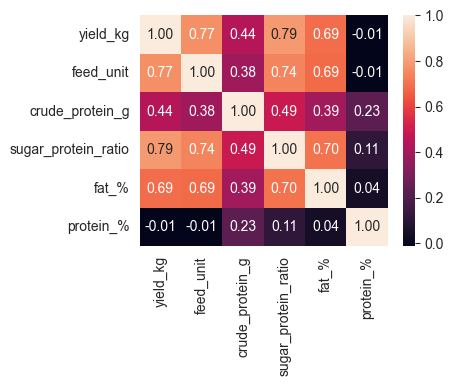

In [30]:
plt.figure(figsize=(4, 3))
sns.heatmap(main_df[num_attr_main].corr(method='spearman'), annot=True, fmt='.2f')
plt.show()

Next, we will create graphs showing the dependency of milk yield on numerical attributes, both overall and separately by categories.

In [31]:
def plot_scatter(df, num_attr, cat_attr):
    for attr in num_attr[1:]:
        # Scatter plot for numerical attributes
        plt.figure(figsize=(4, 3))
        sns.scatterplot(x=df[attr], y=df[num_attr[0]])
        plt.title(f'Dependence of milk yield (kg) on {attr}: {df[attr].corr(df[num_attr[0]]):.2f}', fontsize=10)
        plt.xlabel(attr)
        plt.ylabel(num_attr[0])
        plt.show()
        
        for category in cat_attr:
            # Scatter plot for numerical attributes with categorical grouping
            plt.figure(figsize=(4, 3))
            sns.scatterplot(x=df[attr], y=df[num_attr[0]], hue=df[category], style=df[category])
            plt.title(f'Dependence of milk yield (kg) on {attr} by {category}', fontsize=10)
            plt.xlabel(attr)
            plt.ylabel(num_attr[0])
            plt.legend(title=category)
            plt.show()

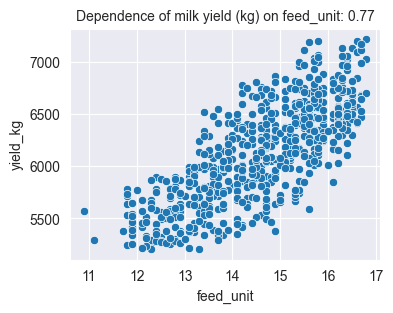

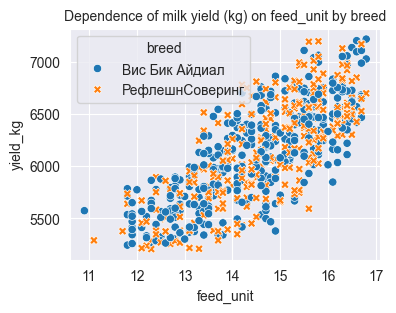

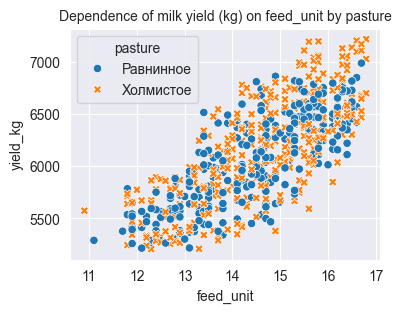

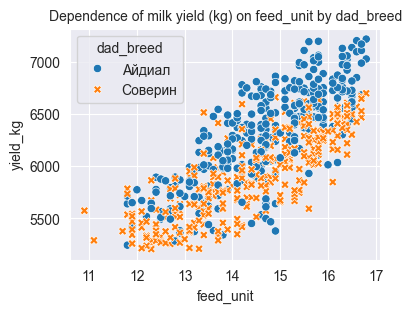

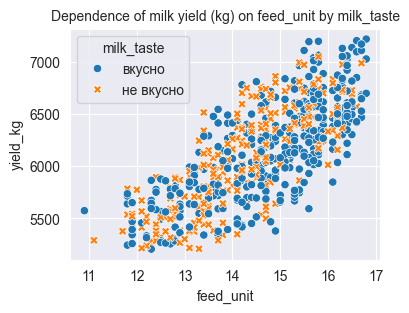

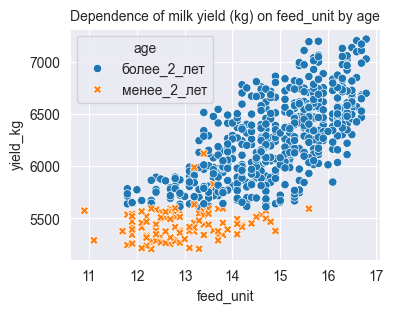

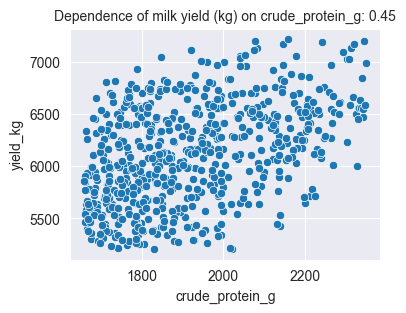

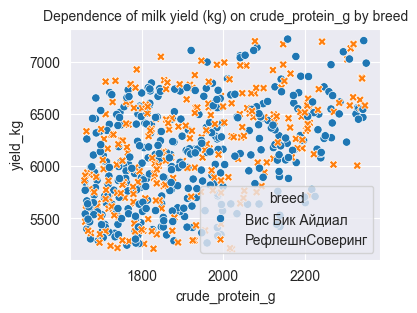

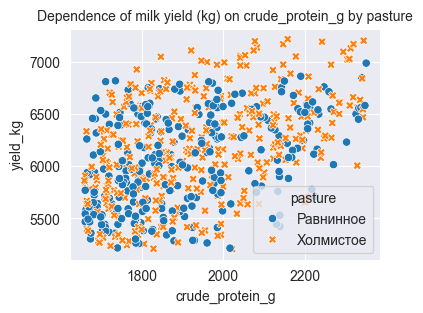

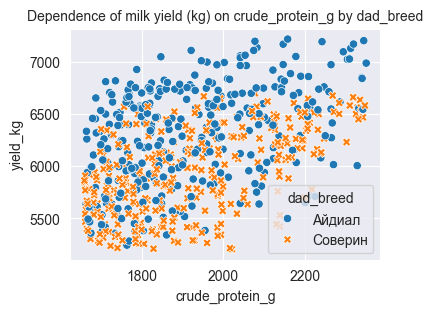

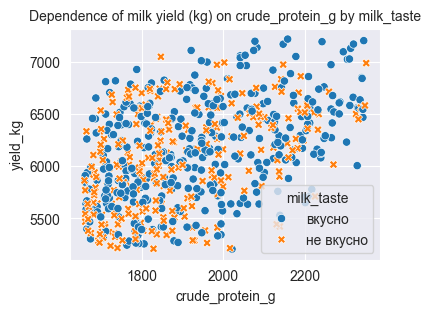

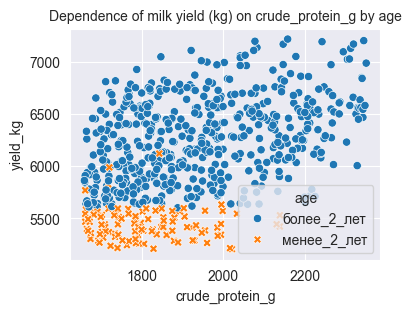

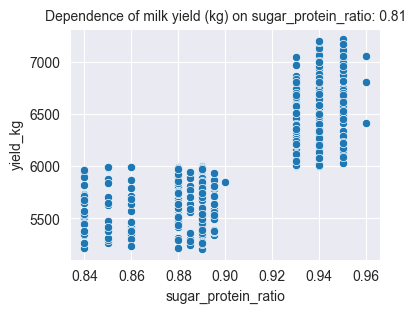

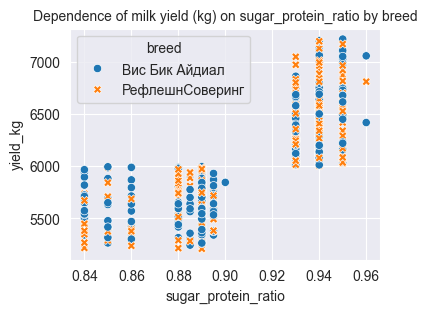

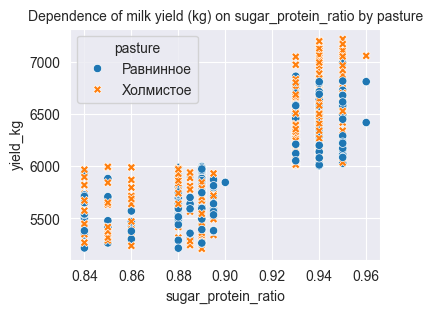

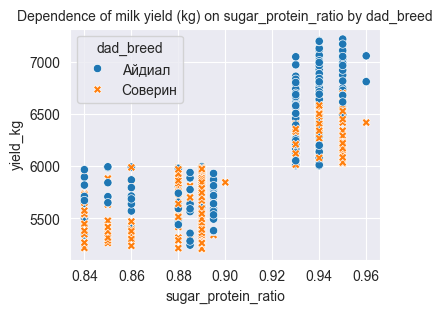

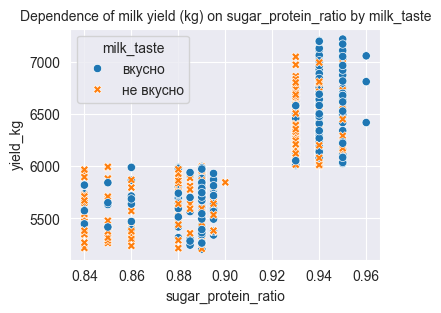

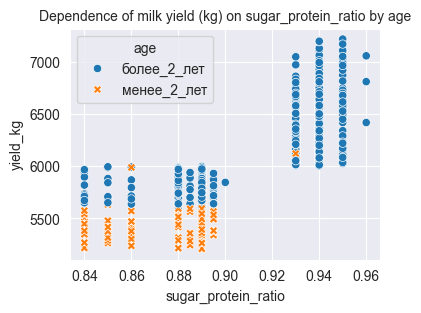

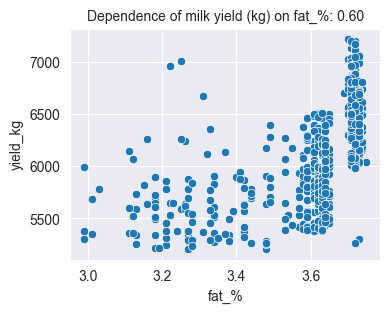

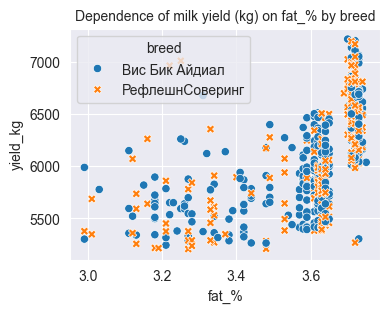

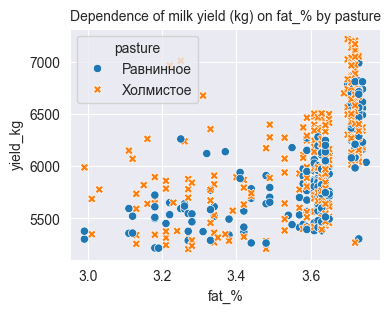

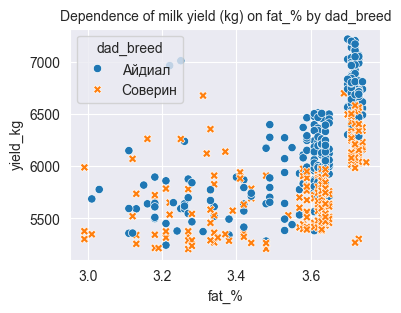

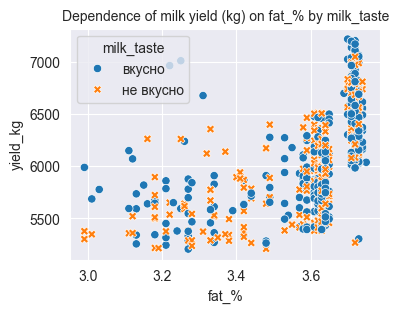

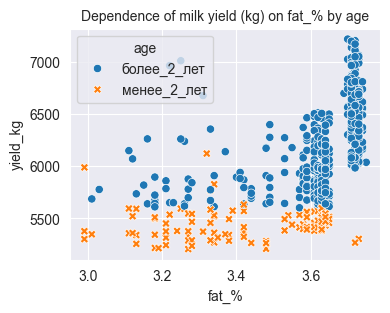

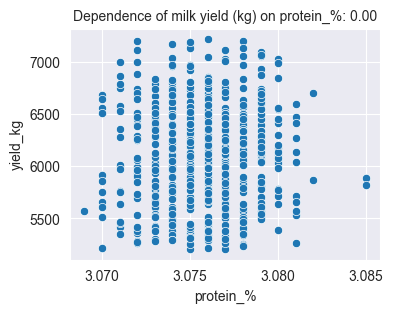

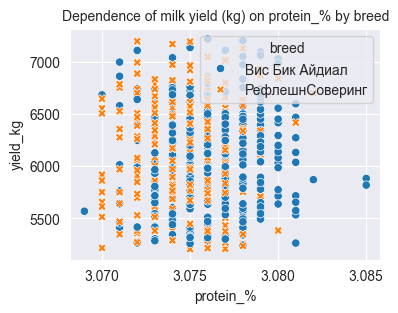

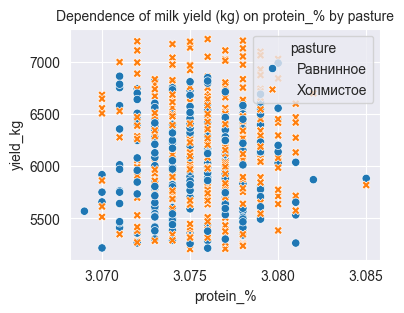

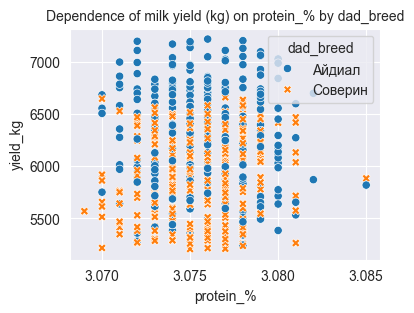

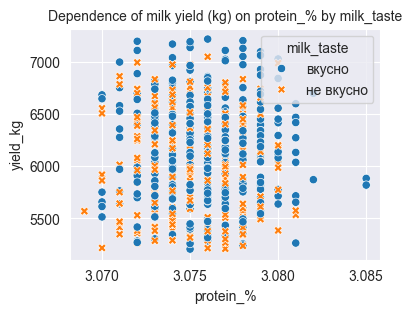

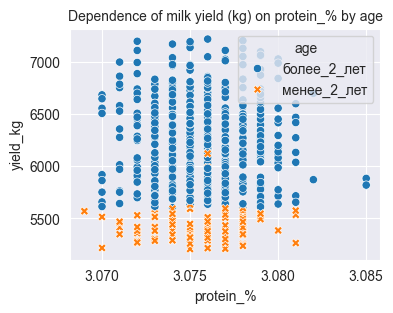

In [32]:
plot_scatter(main_df, num_attr_main, cat_attr_main)

Based on the correlation coefficients, milk yield depends the most on EFE and SPO. This is also evident from the graphs.

All graphs show the dependency of milk yield when divided into groups by the breed of the cow's sire and the cow's age. If the sire's breed is "Ideal," the milk yield is higher than for the sire's breed "Reflection Sovereign." Additionally, milk yield is higher in adult cows.

For many attributes, there is a tendency for milk yield values to align "by columns." This means there are several different milk yield values for the same value of an independent variable. These attributes include EFE, SPO, fat content, and protein content. This is not observed with the protein content in the feed attribute.

## Linear Regression Model

We will select the features that exist in the cow regardless of milk yield. For example, we will keep the feed composition, as the cow eats before milking, and the amount of crude protein may affect the yield. However, the taste of the milk or its fat content is known only after milking, meaning they do not affect the yield.

In [33]:
def attributes_preprocessing(num_attr, cat_attr):
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_attr),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_attr)
    ])
    return preprocessor

In [34]:
def linear_model(df, target, num_attr, cat_attr):
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE
    )
    preprocessor = attributes_preprocessing(num_attr, cat_attr)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_processed, y_train)
    predictions = model.predict(X_test_processed)
    return y_test, predictions, model, preprocessor
    

### Linear Regression with all attributes

In [35]:
linear_regression_1_attributes = ['yield_kg', 'feed_unit', 'crude_protein_g', 'sugar_protein_ratio',\
                                'breed', 'pasture', 'dad_breed', 'age']
linear_regression_1_num = ['feed_unit', 'crude_protein_g', 'sugar_protein_ratio']
linear_regression_1_cat = ['breed', 'pasture', 'dad_breed', 'age']
main_df_linear_1 = main_df.filter(linear_regression_1_attributes)

In [36]:
y_test_1, predictions_1, model_1, preprocessor_1 = linear_model(main_df_linear_1, 'yield_kg', linear_regression_1_num, linear_regression_1_cat)

### Linear regression with modified attributes EFE and SPO

We will take 0.92 as the threshold value for SPO. The graphs show that for SPO values < 0.92, low milk yield is typical. Conversely, for values ≥ 0.92, higher milk yield is observed.

In [37]:
spr = 0.92

main_df['sugar_protein_ratio_boolean'] = main_df['sugar_protein_ratio'].apply(lambda x: 1 if x > spr else 0)
main_df['feed_unit_squared'] = main_df['feed_unit'].apply(lambda x: x**2)
main_df.sample(10)

,id,yield_kg,feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture,dad_breed,fat_%,protein_%,milk_taste,age,sugar_protein_ratio_boolean,feed_unit_squared
615,616,6805,14.9,1863,0.930,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,не вкусно,более_2_лет,1,222.01
125,126,6232,15.8,1879,0.950,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.074,не вкусно,более_2_лет,1,249.64
153,154,6288,15.6,1981,0.940,Вис Бик Айдиал,Равнинное,Соверин,3.71,3.076,вкусно,более_2_лет,1,243.36
349,350,6171,15.3,1966,0.940,РефлешнСоверинг,Равнинное,Соверин,3.73,3.076,вкусно,более_2_лет,1,234.09
274,275,6116,15.7,2221,0.950,РефлешнСоверинг,Равнинное,Соверин,3.72,3.075,вкусно,более_2_лет,1,246.49
423,424,6991,16.7,2349,0.950,Вис Бик Айдиал,Равнинное,Айдиал,3.73,3.080,не вкусно,более_2_лет,1,278.89
406,407,6405,16.3,2206,0.940,РефлешнСоверинг,Равнинное,Соверин,3.72,3.075,вкусно,более_2_лет,1,265.69
359,360,5529,13.4,1733,0.890,РефлешнСоверинг,Холмистое,Соверин,3.34,3.072,не вкусно,менее_2_лет,0,179.56
54,55,5383,13.6,1955,0.895,РефлешнСоверинг,Холмистое,Айдиал,3.53,3.080,не вкусно,менее_2_лет,0,184.96
62,63,6564,16.3,1991,0.930,Вис Бик Айдиал,Холмистое,Айдиал,3.71,3.075,не вкусно,более_2_лет,1,265.69


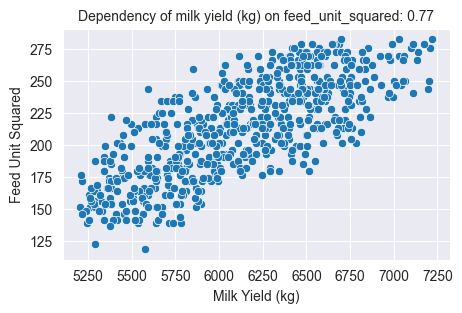

In [38]:
corr_value = main_df['yield_kg'].corr(main_df['feed_unit_squared'])

plt.figure(figsize=(5, 3))
sns.scatterplot(x='yield_kg', y='feed_unit_squared', data=main_df)

plt.title(f"Dependency of milk yield (kg) on feed_unit_squared: {corr_value:.2f}", fontsize=10)

plt.xlabel('Milk Yield (kg)')
plt.ylabel('Feed Unit Squared')

plt.show()

In [39]:
linear_regression_2_attributes = ['yield_kg', 'feed_unit_squared', 'crude_protein_g', 'sugar_protein_ratio_boolean',\
                                'breed', 'pasture', 'dad_breed', 'age']
linear_regression_2_num = ['feed_unit_squared', 'crude_protein_g']
linear_regression_2_cat = ['breed', 'pasture', 'dad_breed', 'age', 'sugar_protein_ratio_boolean']
main_df_linear_2 = main_df.filter(linear_regression_2_attributes)

In [40]:
y_test_2, predictions_2, model_2, preprocessor_2 = linear_model(main_df_linear_2, 'yield_kg', linear_regression_2_num, linear_regression_2_cat)

### Linear regression with a new attribute - sire's name

In [41]:
merged_df = main_df.merge(dad_df, on='id')
merged_df.head()

,id,yield_kg,feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture,dad_breed,fat_%,protein_%,milk_taste,age,sugar_protein_ratio_boolean,feed_unit_squared,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,Барин


In [42]:
merged_df.duplicated().sum()

0

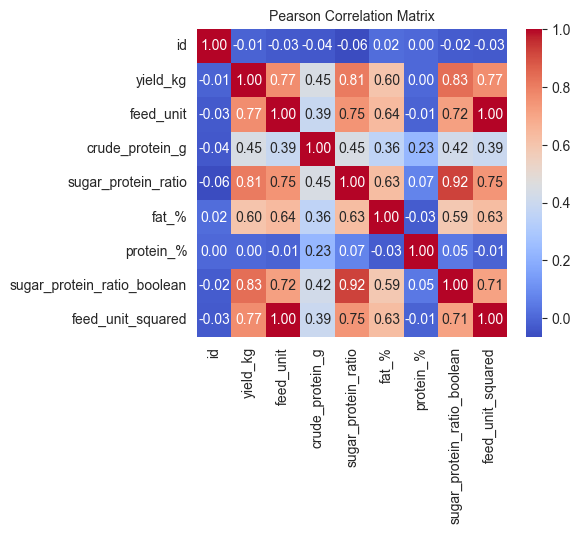

In [43]:
numeric_df = merged_df.select_dtypes(include='number')
pearson_corr = numeric_df.corr(method='pearson')

plt.figure(figsize=(5, 4))
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Pearson Correlation Matrix", fontsize=10)
plt.show()


For the 3rd model, we will not include the Crude Protein attribute. Its correlation coefficient value is 0.45. The correlation coefficients for the percentage of protein and fat content are also low. We have not considered them and will not include them in the 3rd model either.

In [44]:
linear_regression_3_attributes = ['yield_kg', 'feed_unit_squared', 'sugar_protein_ratio_boolean',\
                                'breed', 'pasture', 'dad_breed', 'age', 'dad_name']
linear_regression_3_num = ['feed_unit_squared']
linear_regression_3_cat = ['breed', 'pasture', 'dad_breed', 'age', 'sugar_protein_ratio_boolean', 'dad_name']
main_df_linear_3 = merged_df.filter(linear_regression_3_attributes)

In [45]:
y_test_3, predictions_3, model_3, preprocessor_3 = linear_model(main_df_linear_3, 'yield_kg', linear_regression_3_num, linear_regression_3_cat)

## Models comparison

In [46]:
def linear_results(test_values, predicted_values, title):
    r2 = r2_score(test_values, predicted_values)
    mae = mean_absolute_error(test_values, predicted_values)
    mse = mean_squared_error(test_values, predicted_values)
    rmse = sqrt(mse)
    
    plt.figure(figsize=(3, 2))
    sns.scatterplot(x=predicted_values, y=test_values - predicted_values, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(title, fontsize=10)
    plt.grid(True)
    
    return pd.Series([r2, mae, mse, rmse], index=['r2', 'MAE', 'MSE', 'RMSE']), plt.gcf()

,Model 1,Model 2,Model 3
r2,0.784408,0.818088,0.821670
MAE,164.241945,149.039652,148.699917
MSE,43887.015010,37030.911311,36301.741719
RMSE,209.492279,192.434174,190.530160


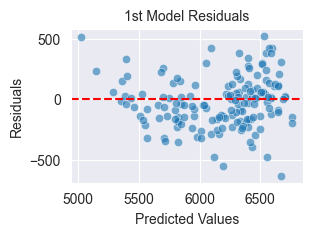

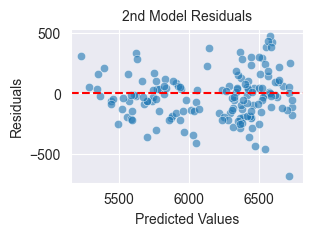

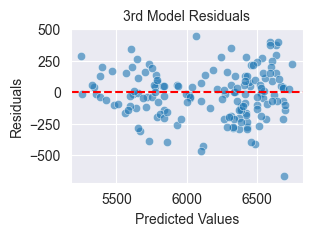

In [47]:
res_1 = linear_results(y_test_1, predictions_1, "1st Model Residuals")
res_2 = linear_results(y_test_2, predictions_2, "2nd Model Residuals")
res_3 = linear_results(y_test_3, predictions_3, "3rd Model Residuals")

results_dict = {
    'Model 1': res_1[0],
    'Model 2': res_2[0],
    'Model 3': res_3[0]
}
results_df = pd.DataFrame(results_dict)
display(results_df)

plt.show(res_1[1])
plt.show(res_2[1])
plt.show(res_3[1])

Based on the metrics and residual plots, the best model is the 3rd one. The residual plots of all three models do not differ significantly. The 1st model shows greater scatter of residuals for larger values of the target variable.

We will use the 3rd model for prediction.

In [48]:
buy_df['feed_unit'] = main_df['feed_unit'].mean() * 1.05
buy_df['crude_protein_g'] = main_df['crude_protein_g'].mean() * 1.05
buy_df['sugar_protein_ratio'] = main_df['sugar_protein_ratio'].mean() * 1.05
buy_df.head()

,breed,pasture,dad_breed,dad_name,current_fat_%,current_protein_%,age,feed_unit,crude_protein_g,sugar_protein_ratio
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744


New values have been added, but since the 3rd model will be used, we need to add the columns that were used to train the model. Also, we will convert SPO to a boolean type, and EFE will be squared.

In [49]:
spr = 0.92

buy_df['sugar_protein_ratio_boolean'] = buy_df['sugar_protein_ratio'].apply(lambda x: 1 if x > spr else 0)
buy_df['feed_unit_squared'] = buy_df['feed_unit'].apply(lambda x: x**2)
buy_df.sample(10)

,breed,pasture,dad_breed,dad_name,current_fat_%,current_protein_%,age,feed_unit,crude_protein_g,sugar_protein_ratio,sugar_protein_ratio_boolean,feed_unit_squared
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138
19,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138


In [50]:
X_buy = buy_df[linear_regression_3_attributes[1:]]
X_buy_processed = preprocessor_3.transform(X_buy)
predictions_buy = model_3.predict(X_buy_processed)

In [51]:
buy_df['yield_kg'] = predictions_buy
buy_df.sample(10)

,breed,pasture,dad_breed,dad_name,current_fat_%,current_protein_%,age,feed_unit,crude_protein_g,sugar_protein_ratio,sugar_protein_ratio_boolean,feed_unit_squared,yield_kg
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6596.711536
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6400.165474
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6272.773280
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6379.410136
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6115.154212
18,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.34,3.069,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6557.338101
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6524.100277
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6600.331414
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6400.165474
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6557.338101


Among all the tested linear regression models, the third one was chosen. The best metrics were obtained when training the model with the attributes 'yield_kg', 'feed_unit_squared', 'sugar_protein_ratio_boolean', 'breed', 'pasture', 'dad_breed', 'age', and 'dad_name'.

## Logistic Regression Model

In [52]:
log_regression_attributes = ['feed_unit', 'crude_protein_g', 'sugar_protein_ratio', \
                                'breed', 'pasture', 'dad_breed', 'fat_%', 'protein_%', 'age', 'milk_taste']
log_regression_num = ['feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_%', 'protein_%']
log_regression_cat = ['breed', 'pasture', 'dad_breed', 'age']
main_df_log = main_df.filter(log_regression_attributes)

In [53]:
main_df_log.head()

,feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture,dad_breed,fat_%,protein_%,age,milk_taste
0,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,более_2_лет,вкусно
1,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,менее_2_лет,вкусно
2,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,более_2_лет,не вкусно
3,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,более_2_лет,не вкусно
4,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,менее_2_лет,вкусно


In [54]:
le = LabelEncoder()
le.fit(main_df_log['milk_taste'])
main_df_log['milk_taste_encoded'] = le.transform(main_df_log['milk_taste'])
label_mapping = {0: 1, 1: 0}
main_df_log['milk_taste_encoded'] = main_df_log['milk_taste_encoded'].map(label_mapping)

X = main_df_log.drop(['milk_taste', 'milk_taste_encoded'], axis=1)
y = main_df_log['milk_taste_encoded']
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
preprocessor = attributes_preprocessing(log_regression_num, log_regression_cat)



X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
model = LogisticRegression()
model.fit(X_train_processed, y_train)
predictions = model.predict(X_test_processed)    

In [55]:
main_df_log.head()

,feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture,dad_breed,fat_%,protein_%,age,milk_taste,milk_taste_encoded
0,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,более_2_лет,вкусно,1
1,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,менее_2_лет,вкусно,1
2,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,более_2_лет,не вкусно,0
3,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,более_2_лет,не вкусно,0
4,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,менее_2_лет,вкусно,1


In [56]:
def log_metrics(y_test, predictions):
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    return accuracy, recall, precision

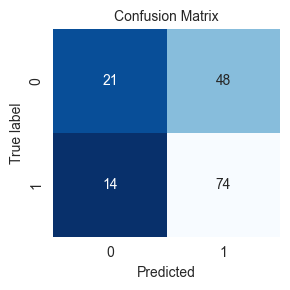

accuracy: 0.6050955414012739
recall: 0.8409090909090909
precision: 0.6065573770491803


In [57]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', cbar=False)
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.title('Confusion Matrix', fontsize=10)
plt.tight_layout()
plt.show()

accuracy, recall, precision = log_metrics(y_test, predictions)
print(f'accuracy: {accuracy}\nrecall: {recall}\nprecision: {precision}')

Precision - How often the model identifies tasteless milk as tasty. If there are too many such cases, the farmer will waste money on buying cows and on the milk these cows produce, as there will be fewer buyers.

Recall - How often the model correctly identifies tasty milk. If there are many cases where tasty milk is identified as tasteless, then the farmer will not buy these cows. In this case, he will not lose money on the purchase, but he will lose potential buyers.

For the farmer, the main priority is tasty milk. Therefore, the model should not predict tasteless milk as tasty. Hence, the needed metric is precision.

Best Precision: 0.88 for Threshold: 0.74


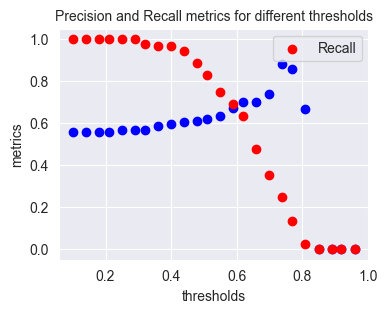

In [58]:
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=24, endpoint=False)]

predicted_probabilities = model.predict_proba(X_test_processed)[:, 1]
precision_values = []
recall_values = []

best_precision = 0.0
best_threshold = 0.0


for threshold in thresholds:
    binary_predictions = (predicted_probabilities >= threshold).astype(int)
    precision = precision_score(y_test, binary_predictions, zero_division=0)
    recall = recall_score(y_test, binary_predictions, zero_division=0)
    precision_values.append(precision)
    recall_values.append(recall)
    if precision > best_precision:
        best_precision = precision
        best_threshold = threshold
        
print(f'Best Precision: {best_precision} for Threshold: {best_threshold}')

plt.figure(figsize=(4, 3))
plt.scatter(thresholds, precision_values, color='blue')
plt.scatter(thresholds, recall_values, color='red', label='Recall')
plt.title('Precision and Recall metrics for different thresholds', fontsize=10)
plt.xlabel('thresholds')
plt.ylabel('metrics')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
buy_df.head()

,breed,pasture,dad_breed,dad_name,current_fat_%,current_protein_%,age,feed_unit,crude_protein_g,sugar_protein_ratio,sugar_protein_ratio_boolean,feed_unit_squared,yield_kg
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6596.711536
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6357.172161
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6272.773280
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6579.576076
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6524.100277


In [60]:
log_regression_attributes[:-1]

['feed_unit',
 'crude_protein_g',
 'sugar_protein_ratio',
 'breed',
 'pasture',
 'dad_breed',
 'fat_%',
 'protein_%',
 'age']

In [61]:
threshold = 0.74

buy_df.rename(columns={'current_fat_%': 'fat_%', 'current_protein_%': 'protein_%'}, inplace=True)
X_buy = buy_df[log_regression_attributes[:-1]]
X_buy_processed = preprocessor.transform(X_buy)
predicted_probabilities_buy_df = model.predict_proba(X_buy_processed)[:, 1]
binary_predictions_buy = (predicted_probabilities_buy_df >= best_threshold).astype(int)

predicted_labels_buy_df = np.where(binary_predictions_buy == 1, 'вкусно', 'не вкусно')

buy_df['milk_taste_predicted'] = predicted_labels_buy_df
buy_df.sample(10)

,breed,pasture,dad_breed,dad_name,fat_%,protein_%,age,feed_unit,crude_protein_g,sugar_protein_ratio,sugar_protein_ratio_boolean,feed_unit_squared,yield_kg,milk_taste_predicted
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6524.100277,не вкусно
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6579.576076,не вкусно
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6272.773280,не вкусно
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6400.165474,не вкусно
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6115.154212,вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6596.711536,вкусно
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6272.773280,не вкусно
16,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6355.417362,вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6557.338101,вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6357.172161,вкусно


Unlike the model predicting milk yield, this model also used attributes known after milking, affecting the milk taste: 'feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'breed', 'pasture', 'dad_breed', 'fat_%', 'protein_%', 'age', 'milk_taste'.

The optimal threshold value for minimizing error is 0.85. With the predicted probabilities divided by this threshold, precision equals 1.

In [62]:
buy_df.shape

(20, 14)

In [63]:
cows_to_buy_df = buy_df.query('yield_kg > 6000 and milk_taste_predicted=="вкусно"')
print(cows_to_buy_df.shape)
display(cows_to_buy_df)

(7, 14)


,breed,pasture,dad_breed,dad_name,fat_%,protein_%,age,feed_unit,crude_protein_g,sugar_protein_ratio,sugar_protein_ratio_boolean,feed_unit_squared,yield_kg,milk_taste_predicted
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6596.711536,вкусно
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6357.172161,вкусно
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6596.711536,вкусно
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6557.338101,вкусно
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6379.410136,вкусно
13,Вис Бик Айдиал,Холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6115.154212,вкусно
16,Вис Бик Айдиал,Холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.276162,2019.947532,0.958744,1,233.361138,6355.417362,вкусно


## Summary

As a result of working with the main_df data, the best linear regression model for predicting cow milk yield was found. Attributes such as breed, pasture type, sire breed, age, SPO, sire's name, and EFE were used to train the model. Using these same attributes from the buy_df data, milk yield values (in kg) were predicted for the cows intended for purchase.

Next, using the logistic regression model, the cows whose milk would taste good were predicted. The precision error was minimized because it is important for the farmer to ensure that no tasteless milk is sold, meaning the model should not predict tasteless milk as tasty.

As a result of this work, the farmer is recommended to purchase 7 cows. The selected cows from the list have a milk yield of more than 6000 kg and produce tasty milk.

For the milk yield prediction model, the SPO and EFE values were transformed. To improve predictions, more attributes can be collected, and the existing attributes can be divided into more classes. For example, age can be divided into different age groups rather than just being more or less than 2 years.

When predicting milk taste, at the client's request, attention was paid to one error - precision. However, there is a risk that the farmer will not buy cows with tasty milk that was incorrectly identified as tasteless. In this case, there are no financial costs for buying the cows, but there are financial losses from unsold milk.